/home/atharva/anaconda3/envs/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Classification Report:
                  precision    recall  f1-score   support

Not Hate Speech       0.49      0.92      0.64    361594
    Hate Speech       0.34      0.04      0.07    364525

       accuracy                           0.48    726119
      macro avg       0.41      0.48      0.35    726119
   weighted avg       0.41      0.48      0.35    726119



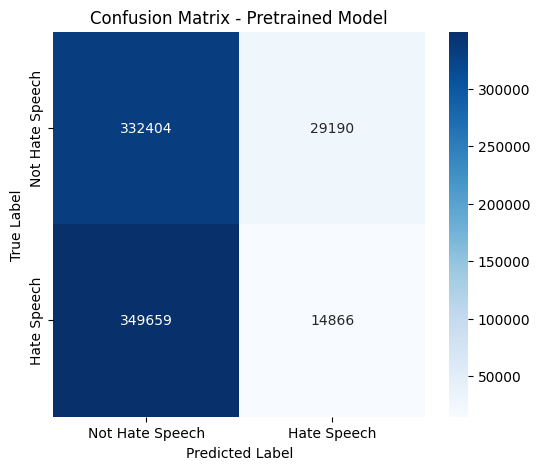

In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import confusion_matrix, classification_report


device = torch.device("cuda" )

# Load tokenizer and pre-trained BERT model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)  # Move model to GPU
model.eval()  # Set to evaluation mode

# Load validation dataset
df = pd.read_csv("HateSpeechDatasetBalanced.csv")  # Load dataset
val_texts = df["Content"].tolist()  # Extract texts
val_labels = df["Label"].tolist()  # Extract true labels

# Efficient batch prediction function
def predict_batch(texts, batch_size=32):
    """Tokenizes and predicts labels in batches."""
    all_preds = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]

        # Tokenize batch
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
        inputs = {key: val.to(device) for key, val in inputs.items()}  # Move to GPU

        with torch.no_grad():
            outputs = model(**inputs)

        # Get predictions
        batch_preds = torch.argmax(outputs.logits, dim=-1).cpu().tolist()  # Move to CPU
        all_preds.extend(batch_preds)

    return all_preds

# Make predictions using the pre-trained model
predicted_labels = predict_batch(val_texts)

# Compute confusion matrix
cm = confusion_matrix(val_labels, predicted_labels)

# Print classification report
print("Classification Report:\n", classification_report(val_labels, predicted_labels, target_names=["Not Hate Speech", "Hate Speech"]))

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Hate Speech", "Hate Speech"], yticklabels=["Not Hate Speech", "Hate Speech"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Pretrained Model")
plt.show()
